In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [2]:
crypto = 'BTC'
fiat = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

data = web.DataReader(f'{crypto}-{fiat}', 'yahoo', start, end)

In [3]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2021-09-06,52853.765625,43285.207031,52660.480469,46811.128906,6.521006e+10,46811.128906
2021-09-07,47334.054688,44561.394531,46827.761719,46091.390625,4.900776e+10,46091.390625
2021-09-08,47261.949219,45669.738281,45774.742188,46391.421875,3.867266e+10,46391.421875


In [4]:
# Preparing Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

In [5]:
x_train = []
y_train = []

In [6]:
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
# Create Neural Network
model = Sequential()

In [8]:
model.add(LSTM(
    units=50, return_sequences=True,
    input_shape=(x_train.shape[1], 1)
))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, shuffle=False, batch_size=32, verbose=1)

Epoch 1/25
78/78 [==============================] - 7s 46ms/step - loss: 0.0094
Epoch 2/25
78/78 [==============================] - 3s 45ms/step - loss: 0.0174
Epoch 3/25
78/78 [==============================] - 4s 45ms/step - loss: 0.0121
Epoch 4/25
78/78 [==============================] - 4s 45ms/step - loss: 0.0036
Epoch 5/25
78/78 [==============================] - 4s 51ms/step - loss: 0.0018
Epoch 6/25
78/78 [==============================] - 4s 53ms/step - loss: 0.0021
Epoch 7/25
78/78 [==============================] - 4s 53ms/step - loss: 0.0026
Epoch 8/25
78/78 [==============================] - 4s 53ms/step - loss: 0.0019
Epoch 9/25
78/78 [==============================] - 4s 54ms/step - loss: 0.0019
Epoch 10/25
78/78 [==============================] - 4s 55ms/step - loss: 0.0018
Epoch 11/25
78/78 [==============================] - 4s 55ms/step - loss: 0.0019
Epoch 12/25
78/78 [==============================] - 4s 57ms/step - loss: 0.0033
Epoch 13/25
78/78 [==================

In [9]:
# Testing model
test_start = dt.datetime(2014,9,16)
test_end = dt.datetime.now()

In [10]:
test_data = web.DataReader(f'{crypto}-{fiat}', 'yahoo', test_start, test_end)

In [11]:
prices = test_data['Close'].values

In [12]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [13]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)


In [14]:
x_test = []

In [15]:
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

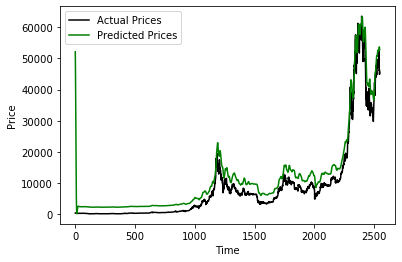

In [17]:
plt.plot(prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()